# Magnetic Reconnection

## BACKGROUND
![image.png](https://scitechdaily.com/images/Magnetic-Reconnection-in-a-Solar-Flare-777x437.jpg?ezimgfmt=ng:webp/ngcb2)

Magnetic Reconnection (MR) is a process in which opposing magnetic field lines merge. If magnetic reconnection occurs between the interplanetary magnetic field (IMF) and Earth’s magnetic field, solar-wind plasma particles are permitted to enter the region of space near Earth (the geospace). When MR occurs, the plasma transport processes inside the geospace are altered, which can lead to space weather events that can damage the satellites we use for communications and navigation or even disrupt power grids that provide our electricity here on Earth.

NASA’s Advanced Composition Explorer (ACE) and Wind missions and NOAA’s Deep Space Climate Observatory (DSCOVR) mission are located at Lagrange point 1 (a location about one million miles towards the Sun from Earth) and routinely measure the IMF. The IMF is a vector that can be characterized by three independent components (X, Y, Z). In the Geocentric Solar Magnetospheric (GSM) Coordinate System, the X-axis points from Earth to the Sun. The Y-axis is defined to be perpendicular to the Earth's magnetic dipole so that the X-Z plane contains the Earth's dipole axis. The positive Z-axis is in the direction of Earth's northern magnetic pole. **A crucial condition for magnetic reconnection is simultaneous occurrence of opposite polarities of the Z components of the IMF and the Z component of Earth’s magnetic field.**

In [776]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import matplotlib.dates as mdates
import datetime
from datetime import datetime
import matplotlib.ticker as ticker

import seaborn as sns 
import pywt

# Go to work...
We are using data from OMNI WEB service of NASA to get a dataset sample from "2018-01-01 00:00:00" to "2023-01-07 23:55:00" with 5-min resolution. Dataset is downloaded from main server https://omniweb.gsfc.nasa.gov/form/omni_min.html and we select only the following variables:

|No|Items|Units|Format|
|---|---|---|---|
|1| Year| | I4|
|2| Day| | I4| 
|3| Hour| | I3|
|4| Minute| | I3|
|5| Field magnitude average| nT| F8.2|
|6| BX| nT (GSE, GSM)| F8.2|
|7| BY| nT (GSE)| F8.2|
|8| BZ| nT (GSE)| F8.2|
|9| Speed| km/s| F8.1|
|10| Proton Density| n/cc| F7.2|
|11| Proton Temperature| K| F9.0|

In [777]:
data_omni=pd.read_csv("omni_5min_KthFfnUcSg.lst.txt",names=["YEAR","DOY","Hour","MIN","B","BX","BY","BZ","S","D","T"],delimiter="\s+")
data_omni.head(10)

,YEAR,DOY,Hour,MIN,B,BX,BY,BZ,S,D,T
0,2018,1,0,0,8.25,1.16,-6.66,-2.89,371.9,13.31,78089.0
1,2018,1,0,5,7.91,1.13,-6.27,-3.46,374.5,13.34,85041.0
2,2018,1,0,10,7.71,-1.04,-3.39,-4.08,374.4,13.41,94335.0
3,2018,1,0,15,8.21,1.80,-5.21,-5.68,378.2,13.37,98421.0
4,2018,1,0,20,8.28,1.66,-5.62,-4.09,381.0,14.69,99955.0
5,2018,1,0,25,8.99,3.28,-8.04,-0.58,381.9,13.18,87514.0
6,2018,1,0,30,7.76,0.14,-0.88,-7.53,390.6,13.47,100503.0
7,2018,1,0,35,8.78,0.48,2.45,-7.63,386.9,14.59,95976.0
8,2018,1,0,40,9.74,2.58,1.24,-7.71,390.2,14.82,87757.0
9,2018,1,0,45,9.19,1.10,1.33,-6.01,391.6,14.52,92366.0


### Handling Missing Information

In the given DataFrame, certain values lack information and are represented by the following pattern in regular expression:
"999*(?:\.9*|\.0)?$"

For example:

999.9 $\newline$
9999.999 $\newline$
999.0

These values are considered placeholders for missing information and should be treated as NaN (Not a Number) for later cleanup.


In [778]:
replaceValues=  [999.9, 999.99, 9999.0, 9999.99, 99999.9, 9999999.0]
data_omni=data_omni.replace(replaceValues,np.nan)

Validate if there are any null values

In [779]:

print(f'There are {data_omni.isin(replaceValues).sum().sum()} [999*(?:\.9*|\.0)?$] values')
print(f'There are {data_omni.isna().sum().sum()} NaN values.')


There are 0 [999*(?:\.9*|\.0)?$] values
There are 198500 NaN values.


### information to consider

In [780]:
data_omni.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527904 entries, 0 to 527903
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   YEAR    527904 non-null  int64  
 1   DOY     527904 non-null  int64  
 2   Hour    527904 non-null  int64  
 3   MIN     527904 non-null  int64  
 4   B       508686 non-null  float64
 5   BX      508686 non-null  float64
 6   BY      508686 non-null  float64
 7   BZ      508686 non-null  float64
 8   S       487412 non-null  float64
 9   D       487412 non-null  float64
 10  T       487260 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 44.3 MB


In [781]:
print("The number of missing data in the variables is (in percentage):")
data_omni.isnull().sum()/len(data_omni)*100

The number of missing data in the variables is (in percentage):


YEAR    0.000000
DOY     0.000000
Hour    0.000000
MIN     0.000000
B       3.640435
BX      3.640435
BY      3.640435
BZ      3.640435
S       7.670334
D       7.670334
T       7.699127
dtype: float64

we eliminate null values

In [782]:
data_omni = data_omni.dropna(how='any')
data_omni.info()

<class 'pandas.core.frame.DataFrame'>
Index: 487127 entries, 0 to 527903
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   YEAR    487127 non-null  int64  
 1   DOY     487127 non-null  int64  
 2   Hour    487127 non-null  int64  
 3   MIN     487127 non-null  int64  
 4   B       487127 non-null  float64
 5   BX      487127 non-null  float64
 6   BY      487127 non-null  float64
 7   BZ      487127 non-null  float64
 8   S       487127 non-null  float64
 9   D       487127 non-null  float64
 10  T       487127 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 44.6 MB


### Combining Time Columns into Datetime Index
We simplify the columns YEAR, DOY, Hour, MIN into a single datetime column with the format '%Y%m%d %H:%M:%S'. Additionally, we set this datetime column as the index of our DataFrame.


In [783]:
columns = ['YEAR', 'DOY', 'Hour', 'MIN']
data_omni['datetime'] = pd.to_datetime(data_omni[columns[:2]].agg(lambda x : ''.join(map(str,x)), axis = 1), format = '%Y%j') + pd.to_timedelta(data_omni['Hour'], unit='h') + pd.to_timedelta(data_omni['MIN'], unit = 's')
data_omni.set_index('datetime', inplace=True)
data_omni=data_omni.drop(columns = columns)
data_omni

,B,BX,BY,BZ,S,D,T
datetime,,,,,,,
2018-01-01 00:00:00,8.25,1.16,-6.66,-2.89,371.9,13.31,78089.0
2018-01-01 00:00:05,7.91,1.13,-6.27,-3.46,374.5,13.34,85041.0
2018-01-01 00:00:10,7.71,-1.04,-3.39,-4.08,374.4,13.41,94335.0
2018-01-01 00:00:15,8.21,1.80,-5.21,-5.68,378.2,13.37,98421.0
2018-01-01 00:00:20,8.28,1.66,-5.62,-4.09,381.0,14.69,99955.0
...,...,...,...,...,...,...,...
2023-01-07 23:00:35,6.06,4.09,2.24,3.40,401.8,5.42,106468.0
2023-01-07 23:00:40,6.27,4.39,2.76,3.32,400.4,5.64,86628.0
2023-01-07 23:00:45,5.89,4.39,-1.48,3.16,396.7,5.40,116702.0


In [784]:
print("Some statistics...")
data_omni.describe().T

Some statistics...


,count,mean,std,min,25%,50%,75%,max
B,487127.0,5.035385,2.468837,0.22,3.48,4.46,5.91,30.60
BX,487127.0,0.145636,3.096670,-16.54,-2.20,0.25,2.47,18.87
BY,487127.0,-0.338796,3.528378,-24.14,-2.67,-0.46,2.08,23.48
BZ,487127.0,-0.018501,2.705771,-23.47,-1.44,-0.02,1.38,26.10
S,487127.0,407.294680,84.832945,256.30,342.20,387.70,457.00,866.10
D,487127.0,6.571974,4.861534,0.07,3.48,5.26,8.14,72.16
T,487127.0,78329.469652,72568.322780,3472.00,30037.00,55587.00,101972.50,1879742.00


In the following we are going to take a particular date range for analysis while preserving the original frequency of the data for now.
To do this we filter our dataset among the dates of the desired range...


### Choose desired start and end dates for the analysis

In [785]:
#Determining frequency

# Determining start and end dates:
start=input("Select the start date to interval in format YYYYMMDD:")
end=input("Select the end date to interval in format YYYYMMDD:")
#"20200101","20200110"
data_omni=data_omni[(data_omni.index>=start)&(data_omni.index<=end)]

### Some plot from data

In [786]:
#TODO: POSIBLEMENTE ELIMINAR
aux = data_omni[['B', 'BX','BY','BZ']]
palette = sns.color_palette("tab10")

### Magnetic Field Components Over Time

Creates a grid of 2x2 subplots with a specified figure size where each subplot represents a different magnetic field component (B, Bx, By or Bz).

each subplot has 2 graphs: the field component and the same with exponential weighted functions.

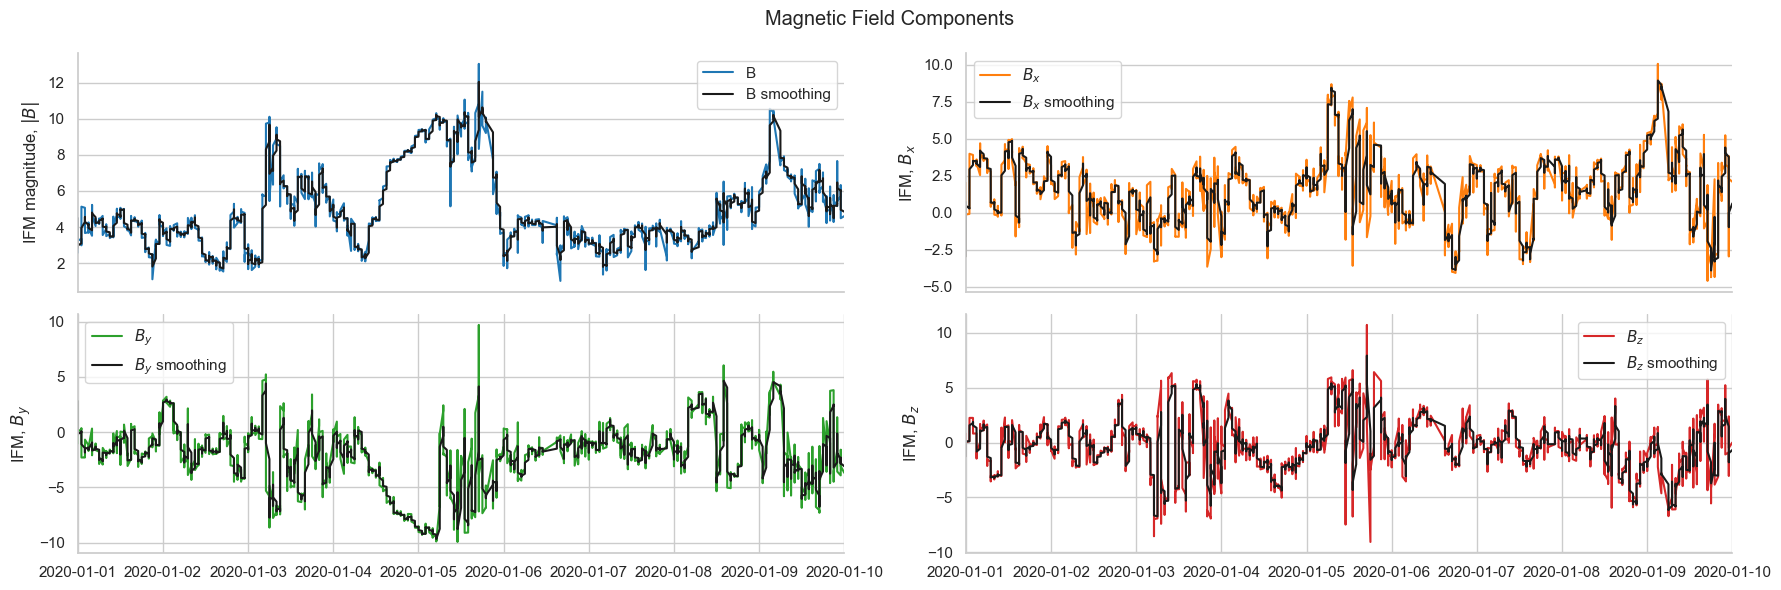

In [787]:
alpha = 0.3 #we define alpha for smoothin

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2, figsize = (18,6))
fig.suptitle('Magnetic Field Components')
sns.despine(fig)

#Plots
sns.lineplot(aux['B'], ax = ax1, color = palette[0],label = 'B')
sns.lineplot(aux['B'].ewm(alpha = alpha).mean(), ax = ax1,  color = 'k', label = 'B smoothing')
sns.lineplot(aux['BX'], ax = ax2, color = palette[1], label = r'$B_x$')
sns.lineplot(aux['BX'].ewm(alpha = alpha).mean(), ax = ax2, color ='k', label = r'$B_x$ smoothing')
sns.lineplot(aux['BY'], ax = ax3, color = palette[2], label = r'$B_y$')
sns.lineplot(aux['BY'].ewm(alpha = alpha).mean(), ax = ax3, color = 'k', label = r'$B_y$ smoothing')
sns.lineplot(aux['BZ'], ax = ax4, color = palette[3], label = r'$B_z$')
sns.lineplot(aux['BZ'].ewm(alpha = alpha).mean(), ax = ax4, color = 'k', label = r'$B_z$ smoothing')


#subplot configurations
ax1.set(ylabel= r"IFM magnitude, $|B|$", xlabel= None, xlim=(data_omni.index.min(), data_omni.index.max()), xticks= ([]))
ax2.set(ylabel= r'IFM, $B_x$', xlabel= None, xlim=(data_omni.index.min(), data_omni.index.max()), xticks= ([]))
ax3.set(ylabel= r'IFM, $B_y$', xlabel= None,xlim=(data_omni.index.min(), data_omni.index.max()))
ax4.set(ylabel= r'IFM, $B_z$', xlabel= None, xlim=(data_omni.index.min(), data_omni.index.max()))


plt.tight_layout()
plt.show()

### Smoothing to print using relplot

The same plot as above is printed, but this time a subplot is used to represent all components. Smoothing is also performed to improve the appearance.

Note: the data to be plotted is sectioned into a separate dataFrame.



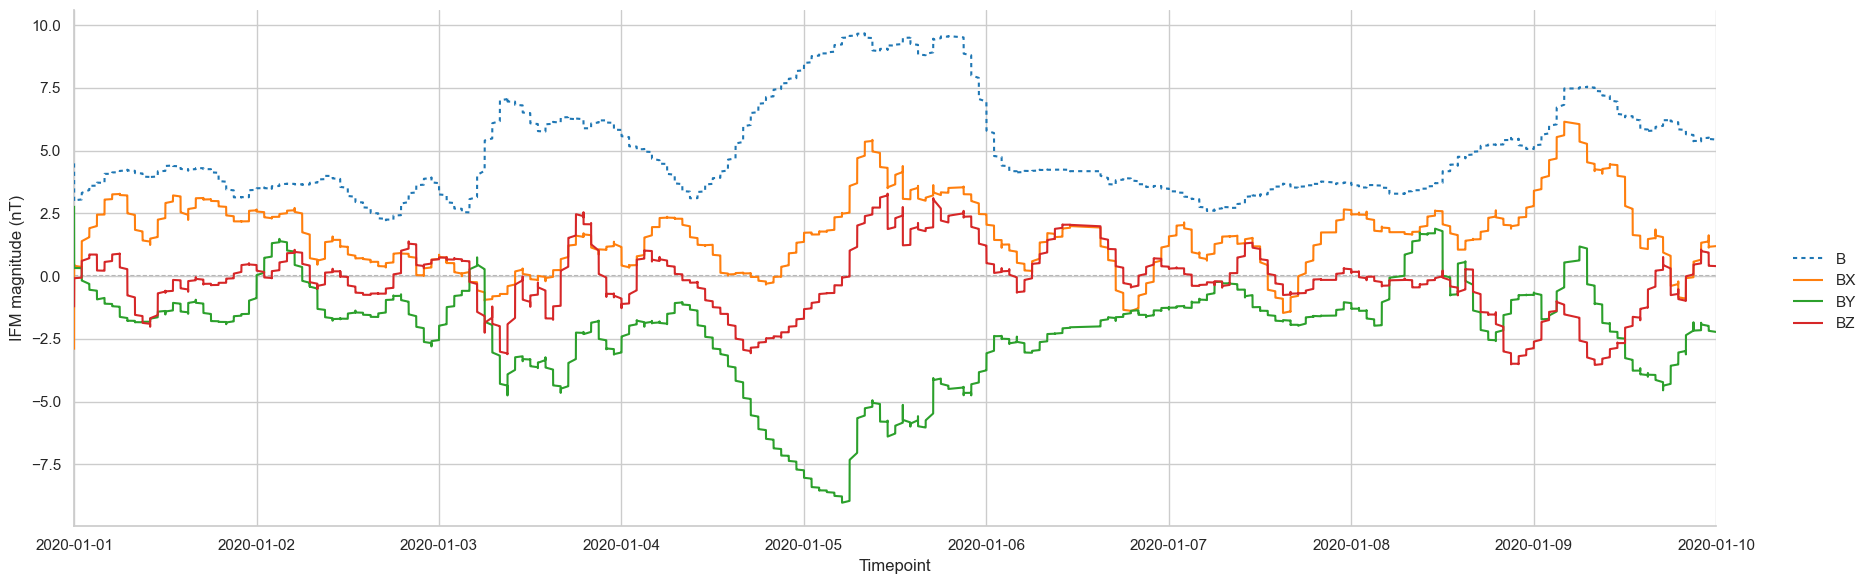

In [788]:
alpha = 0.03 #we define alpha for smoothin
MagneticField = pd.DataFrame({
    'B': data_omni['B'].ewm(alpha=alpha).mean(),
    'BX': data_omni['BX'].ewm(alpha=alpha).mean(),
    'BY': data_omni['BY'].ewm(alpha=alpha).mean(),
    'BZ': data_omni['BZ'].ewm(alpha=alpha).mean(),
})

g = sns.relplot(
    data = MagneticField, 
    kind= 'line',
    height= 6, 
    aspect= 3,
    zorder = 5,
    palette= palette[:4],
    dashes = [(2,2), (1,0), (1,0), (1,0)]
)

(g.set(xlim=(data_omni.index.min(), data_omni.index.max()))
  .map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels("Timepoint", "IFM magnitude (nT)")
  .tight_layout(w_pad=0))


## Speed, Density and Temperature Plot

Supporting plots of the variables temperature (Kelvin Degree), density (m/cc) and speed (km/sec) for the same selected time period.

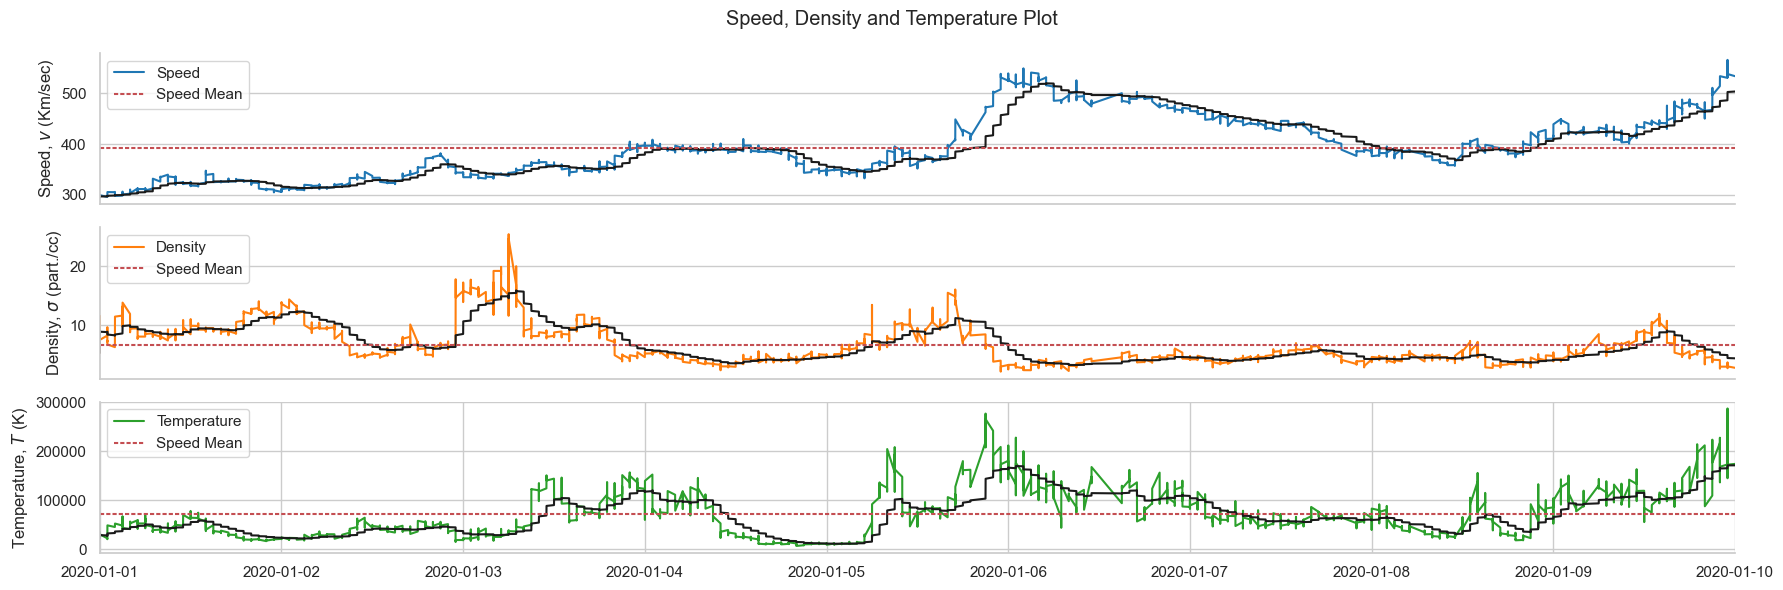

In [789]:
alpha = 0.03
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 6))
sns.despine(fig)

fig.suptitle('Speed, Density and Temperature Plot')

# plots
sns.lineplot(data_omni['S'], ax=ax1, label='Speed', color= palette[0])
sns.lineplot(data_omni['S'].ewm(alpha=alpha).mean(), ax=ax1, color='k')
sns.lineplot(data_omni['D'], ax=ax2, label='Density', color= palette[1])
sns.lineplot(data_omni['D'].ewm(alpha=alpha).mean(), ax=ax2, color='k')
sns.lineplot(data_omni['T'], ax=ax3, label='Temperature', color = palette[2])
sns.lineplot(data_omni['T'].ewm(alpha=alpha).mean(), ax=ax3, color='k')


# we define the properties of the subplots
ax1.set(ylabel=r"Speed, $v$ (Km/sec)", xlabel=None, xlim=(data_omni.index.min(), data_omni.index.max()), xticks= ([]))
ax2.set(ylabel=r'Density, $\sigma$ (part./cc)', xlabel=None, xlim=(data_omni.index.min(), data_omni.index.max()),  xticks= ([]))
ax3.set(ylabel=r'Temperature, $T$ (K)', xlabel=None, xlim=(data_omni.index.min(), data_omni.index.max()))

# we add a horizontal line for the averages
ax1.axhline(data_omni['S'].mean(), color='r', dashes=(2, 1), label='Speed Mean')
ax2.axhline(data_omni['D'].mean(), color='r', dashes=(2, 1), label='Speed Mean')
ax3.axhline(data_omni['T'].mean(), color='r', dashes=(2, 1), label='Speed Mean')

#legends
ax1.legend(loc=2)
ax2.legend(loc=2)
ax3.legend(loc=2)

plt.tight_layout()
plt.show()


### Histogram

the probability distribution of all events is shown:  
- magnetic field and its components (Bx, By, Bz)
- Temperature
- Velocity
- Density 


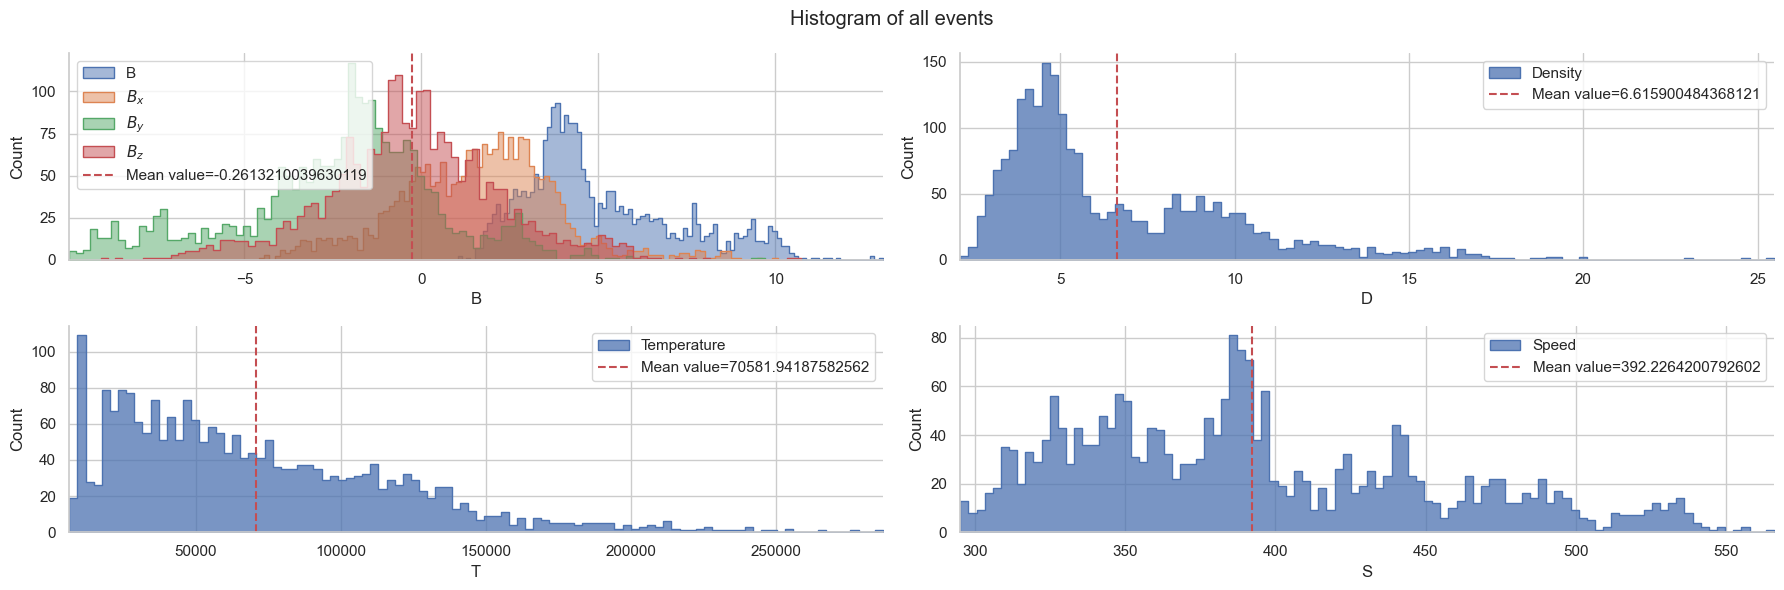

In [790]:

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2, figsize = (18,6))
fig.suptitle('Histogram of all events')
sns.despine(fig)

#plot 1 -> magnetic fields
sns.histplot(
    data = data_omni['B'],
    bins = 100, 
    element= 'step',
    alpha = 0.5,
    ax = ax1,
    label = 'B'
)
sns.histplot(
    data = data_omni['BX'],
    bins = 100, 
    element= 'step',
    alpha = 0.5,
    ax = ax1,
    label = r'$B_x$'
)
sns.histplot(
    data = data_omni['BY'],
    bins = 100, 
    element= 'step',
    alpha = 0.5,
    ax = ax1,
    label = r'$B_y$'
)
sns.histplot(
    data = data_omni['BZ'],
    bins = 100, 
    element= 'step',
    alpha = 0.5,
    ax = ax1,
    label = r'$B_z$'
)
ax1.set(xlim = (data_omni[['B','BX','BY','BZ']].min().min(), data_omni[['B','BX','BY','BZ']].max().max()))
ax1.axvline(data_omni["BZ"].mean(),color="r",linestyle="--",label="Mean value={}".format(data_omni["BZ"].mean()))
ax1.legend(loc = 2)

#plot 2 -> density
sns.histplot(
    data = data_omni['D'],
    bins = 100, 
    element= 'step',
    ax = ax2,
    label = 'Density'
)
ax2.set(xlim = (data_omni['D'].min(), data_omni['D'].max()))
ax2.axvline(data_omni["D"].mean(),color="r",linestyle="--",label="Mean value={}".format(data_omni["D"].mean()))
ax2.legend();

#plot 3 -> temperature
sns.histplot(
    data = data_omni['T'],
    bins = 100, 
    element= 'step',
    ax = ax3,
    label = 'Temperature'
)
ax3.set(xlim = (data_omni['T'].min(), data_omni['T'].max()))
ax3.axvline(data_omni["T"].mean(),color="r",linestyle="--",label="Mean value={}".format(data_omni["T"].mean()))
ax3.legend();

#plot 4 -> speed
sns.histplot(
    data = data_omni['S'],
    bins = 100, 
    element= 'step', 
    ax = ax4,
    label = 'Speed'
)
ax4.set(xlim = (data_omni['S'].min(), data_omni['S'].max()))
ax4.axvline(data_omni["S"].mean(),color="r",linestyle="--",label="Mean value={}".format(data_omni["S"].mean()))
ax4.legend();

plt.tight_layout()
plt.show()


In [791]:
print(r"For this period the mean value of Bz-componet of IMF is = {}".format(data_omni["BZ"].mean()))
print(r"For this period the mean value of Flow Speed is = {}".format(data_omni["S"].mean()))
print(r"For this period the mean value of Proton Density is = {}".format(data_omni["D"].mean()))
print(r"For this period the mean value of Temperature is = {}".format(data_omni["T"].mean()))

For this period the mean value of Bz-componet of IMF is = -0.2613210039630119
For this period the mean value of Flow Speed is = 392.2264200792602
For this period the mean value of Proton Density is = 6.615900484368121
For this period the mean value of Temperature is = 70581.94187582562


Focus here in the z-componet of magnetic field...

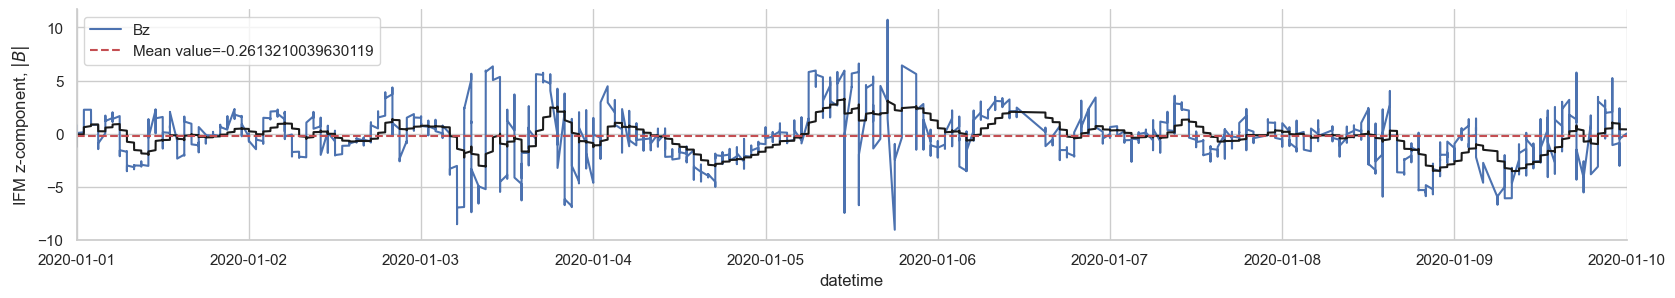

In [792]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.despine(fig)

sns.lineplot(aux['BZ'], ax = ax, label = 'Bz')
sns.lineplot(aux['BZ'].ewm(alpha = 0.03).mean(), color = 'k', ax = ax)
plt.axhline(data_omni["BZ"].mean(),color="r",linestyle="--",label="Mean value={}".format(data_omni["BZ"].mean()))
ax.set(ylabel = r'IFM z-component, $|B|$',xlim=(data_omni.index.min(), data_omni.index.max()))
plt.legend(loc = 2)
plt.show()

## Second approach: Detecting polarity changes...

The amount of magnetic reconnections that occur on the Sun varies over time and depends on several factors, including the solar cycle. During the solar cycle, which is approximately 11 years long, the Sun's magnetic activity fluctuates. During periods of maximum solar activity, such as solar maximum, more solar flares and magnetic reconnection events occur than during periods of minimum solar activity.

On average, during solar maximum, several solar flares can occur per day, and many of these flares are associated with magnetic reconnections in the solar atmosphere. However, it is important to note that the exact number of magnetic reconnections can vary widely from day to day and even from solar flare to solar flare.

In [793]:
# Defining a function to detect magnetic reconnection
def detect_reconnection(row):
    imf_x, imf_y, imf_z, temperature, density, velocity = row['BX'], row['BY'], row['BZ'], row['T'], row['D'], row['S']
    temperature_threshold=data_omni["T"].mean()
    density_threshold=data_omni["D"].mean()
    velocity_threshold=data_omni["S"].mean()
    # Check the conditions for magnetic reconnection in 2D
    if imf_z < 0 and temperature > temperature_threshold and density > density_threshold and velocity > velocity_threshold:
        return "Magnetic Reconnection Detected"
    else:
        return "No Magnetic Reconnection"

data_omni = data_omni.copy()
data_omni.loc[:, 'RM_ind'] = data_omni.dropna().apply(detect_reconnection, axis=1)


resulting dataframe after executing the function

In [794]:
data_omni

,B,BX,BY,BZ,S,D,T,RM_ind
datetime,,,,,,,,
2020-01-01 00:00:00,4.49,-2.93,2.80,-1.24,295.6,5.31,24010.0,No Magnetic Reconnection
2020-01-01 00:00:10,2.99,2.03,1.19,0.35,297.7,7.63,33936.0,No Magnetic Reconnection
2020-01-01 00:00:15,3.26,0.81,1.07,-0.30,296.3,8.61,34855.0,No Magnetic Reconnection
2020-01-01 00:00:20,2.69,0.11,0.06,-0.26,295.2,8.93,27156.0,No Magnetic Reconnection
2020-01-01 00:00:25,2.58,0.96,0.30,0.06,299.7,8.84,27281.0,No Magnetic Reconnection
...,...,...,...,...,...,...,...,...
2020-01-09 23:00:40,5.14,-2.81,-2.21,-3.04,565.8,3.14,144504.0,No Magnetic Reconnection
2020-01-09 23:00:45,4.78,-2.55,-2.70,-2.28,555.6,3.71,286908.0,No Magnetic Reconnection
2020-01-09 23:00:50,4.90,-0.97,-3.42,0.29,542.3,2.71,170455.0,No Magnetic Reconnection


we filter and print to be able to see at what moment a magnetic reconnection occurs

In [795]:
data_omni[data_omni["RM_ind"]=="Magnetic Reconnection Detected"]

,B,BX,BY,BZ,S,D,T,RM_ind
datetime,,,,,,,,
2020-01-05 18:00:40,11.50,-0.22,-2.09,-9.05,422.7,6.86,179470.0,Magnetic Reconnection Detected
2020-01-05 18:00:45,9.81,5.25,-6.71,-0.97,419.5,8.21,152574.0,Magnetic Reconnection Detected
2020-01-05 18:00:50,11.39,4.94,-5.31,-4.92,416.6,7.96,153883.0,Magnetic Reconnection Detected
2020-01-05 18:00:55,9.62,3.32,-7.35,-2.47,428.2,7.31,160940.0,Magnetic Reconnection Detected
2020-01-05 19:00:00,9.21,2.76,-6.82,-0.38,420.2,9.07,161825.0,Magnetic Reconnection Detected
...,...,...,...,...,...,...,...,...
2020-01-09 14:00:20,4.69,-0.90,-3.86,-2.34,445.8,10.90,93235.0,Magnetic Reconnection Detected
2020-01-09 14:00:25,4.85,-1.08,-4.17,-2.08,446.8,11.62,98236.0,Magnetic Reconnection Detected
2020-01-09 14:00:30,5.57,-0.79,-5.33,-1.21,446.4,10.41,105979.0,Magnetic Reconnection Detected


We show the frequency of the number of magnetic reconnections occurring in the range specified at the beginning.

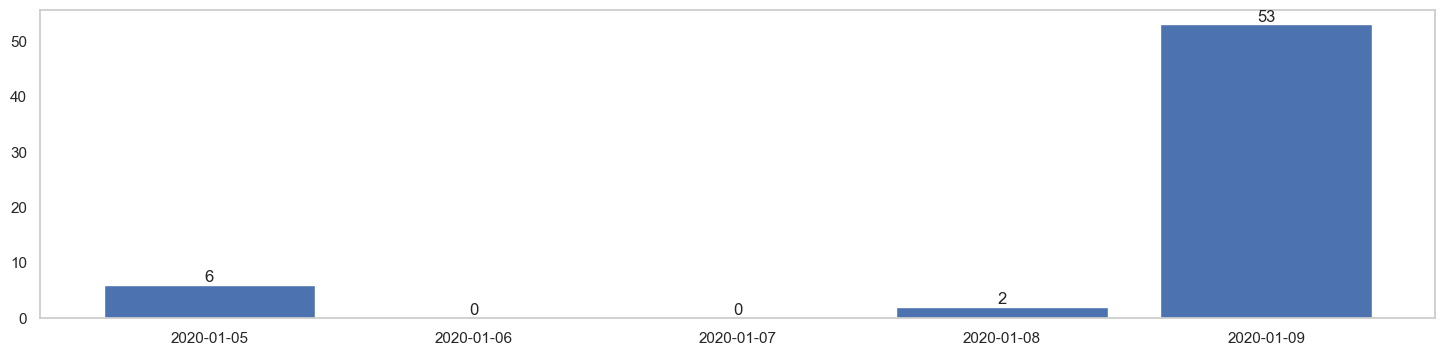

In [796]:
dat=data_omni[data_omni["RM_ind"]=="Magnetic Reconnection Detected"].resample("D").size()
fig, ax = plt.subplots(figsize=(18,4))
ax.bar(dat.index,dat)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.bar_label(ax.containers[0])
plt.grid()
plt.show()

we show in which epoch there was more than 1 magnetic reconnection, this is obtained thanks to the previous graph.

In [797]:
dat[dat>0].index.ravel()

DatetimeIndex(['2020-01-05', '2020-01-08', '2020-01-09'], dtype='datetime64[ns]', name='datetime', freq=None)

Some conclusions and information on the results obtained 

In [798]:
print("For this period we detect magnetic reconection in {} days".format(len(dat[dat>0].index.ravel())))
print("The average of magnetic reconection number in this period is {} per day".format(dat[dat>0].mean().round().astype(int)))
print("The standard deviation of magnetic reconection number in this period is {} per day".format(dat[dat>0].std()))

For this period we detect magnetic reconection in 3 days
The average of magnetic reconection number in this period is 20 per day
The standard deviation of magnetic reconection number in this period is 28.36077102854105 per day


In [799]:
data_omni[data_omni["BZ"]<0]

,B,BX,BY,BZ,S,D,T,RM_ind
datetime,,,,,,,,
2020-01-01 00:00:00,4.49,-2.93,2.80,-1.24,295.6,5.31,24010.0,No Magnetic Reconnection
2020-01-01 00:00:15,3.26,0.81,1.07,-0.30,296.3,8.61,34855.0,No Magnetic Reconnection
2020-01-01 00:00:20,2.69,0.11,0.06,-0.26,295.2,8.93,27156.0,No Magnetic Reconnection
2020-01-01 00:00:30,2.67,0.92,-0.09,-0.18,297.1,10.10,30551.0,No Magnetic Reconnection
2020-01-01 00:00:40,2.83,-0.22,0.00,-0.47,296.4,9.22,26660.0,No Magnetic Reconnection
...,...,...,...,...,...,...,...,...
2020-01-09 23:00:30,5.17,-0.05,-2.69,-2.16,556.0,3.39,169488.0,No Magnetic Reconnection
2020-01-09 23:00:35,5.33,-2.94,-1.59,-2.94,554.1,3.09,167250.0,No Magnetic Reconnection
2020-01-09 23:00:40,5.14,-2.81,-2.21,-3.04,565.8,3.14,144504.0,No Magnetic Reconnection


In [811]:
data_omni_total=data_omni.dropna().copy()
data_omni_total['RM_ind'] = data_omni_total["BZ"]<0

We perform continuous wavelet transform (CWT) using the Morlet wavelet, which is commonly used for analyzing oscillatory behavior.
The CWT coefficients are plotted, showing the time-frequency representation of the data. Transient features or oscillations associated with magnetic reconnection events may manifest as distinct patterns in this plot.

In [802]:
# Perform continuous wavelet transform (CWT)
wavelet = 'morl'  # Morlet wavelet is commonly used
magnetic_field=data_omni_total["BZ"].dropna()
time=range(len(magnetic_field))
coeffs, freqs = pywt.cwt(magnetic_field, scales=np.arange(1, 100), wavelet=wavelet)

we show the results

In [803]:
np.array(list(magnetic_field.index))

array([Timestamp('2020-01-01 00:00:00'), Timestamp('2020-01-01 00:00:10'),
       Timestamp('2020-01-01 00:00:15'), ...,
       Timestamp('2020-01-09 23:00:50'), Timestamp('2020-01-09 23:00:55'),
       Timestamp('2020-01-10 00:00:00')], dtype=object)

In [804]:
coeffs

array([[ 0.19275536,  0.07224096, -0.18336828, ..., -0.18837293,
        -0.25856971,  0.08456508],
       [-0.39713553, -0.11853968,  0.56030104, ...,  0.34885125,
         0.23606491, -0.52859048],
       [-0.54713769, -0.14697724,  0.57767022, ...,  0.41113219,
         0.53967256, -0.46787309],
       ...,
       [ 2.68487576,  3.50515258,  4.0271318 , ...,  5.53654035,
         3.9082269 ,  4.75360178],
       [ 3.13887768,  3.95576802,  4.26861622, ...,  4.68175829,
         4.63825677,  4.3802902 ],
       [ 3.4677678 ,  4.03310923,  4.39055943, ...,  5.04074571,
         4.33865183,  4.49233193]])

In [805]:
freqs

array([0.8125    , 0.40625   , 0.27083333, 0.203125  , 0.1625    ,
       0.13541667, 0.11607143, 0.1015625 , 0.09027778, 0.08125   ,
       0.07386364, 0.06770833, 0.0625    , 0.05803571, 0.05416667,
       0.05078125, 0.04779412, 0.04513889, 0.04276316, 0.040625  ,
       0.03869048, 0.03693182, 0.03532609, 0.03385417, 0.0325    ,
       0.03125   , 0.03009259, 0.02901786, 0.02801724, 0.02708333,
       0.02620968, 0.02539062, 0.02462121, 0.02389706, 0.02321429,
       0.02256944, 0.02195946, 0.02138158, 0.02083333, 0.0203125 ,
       0.01981707, 0.01934524, 0.01889535, 0.01846591, 0.01805556,
       0.01766304, 0.01728723, 0.01692708, 0.01658163, 0.01625   ,
       0.01593137, 0.015625  , 0.01533019, 0.0150463 , 0.01477273,
       0.01450893, 0.01425439, 0.01400862, 0.01377119, 0.01354167,
       0.01331967, 0.01310484, 0.01289683, 0.01269531, 0.0125    ,
       0.01231061, 0.01212687, 0.01194853, 0.01177536, 0.01160714,
       0.01144366, 0.01128472, 0.01113014, 0.01097973, 0.01083

We plot the original magnetic field, in addition to the Continuous Wavelet Transform (CWT).

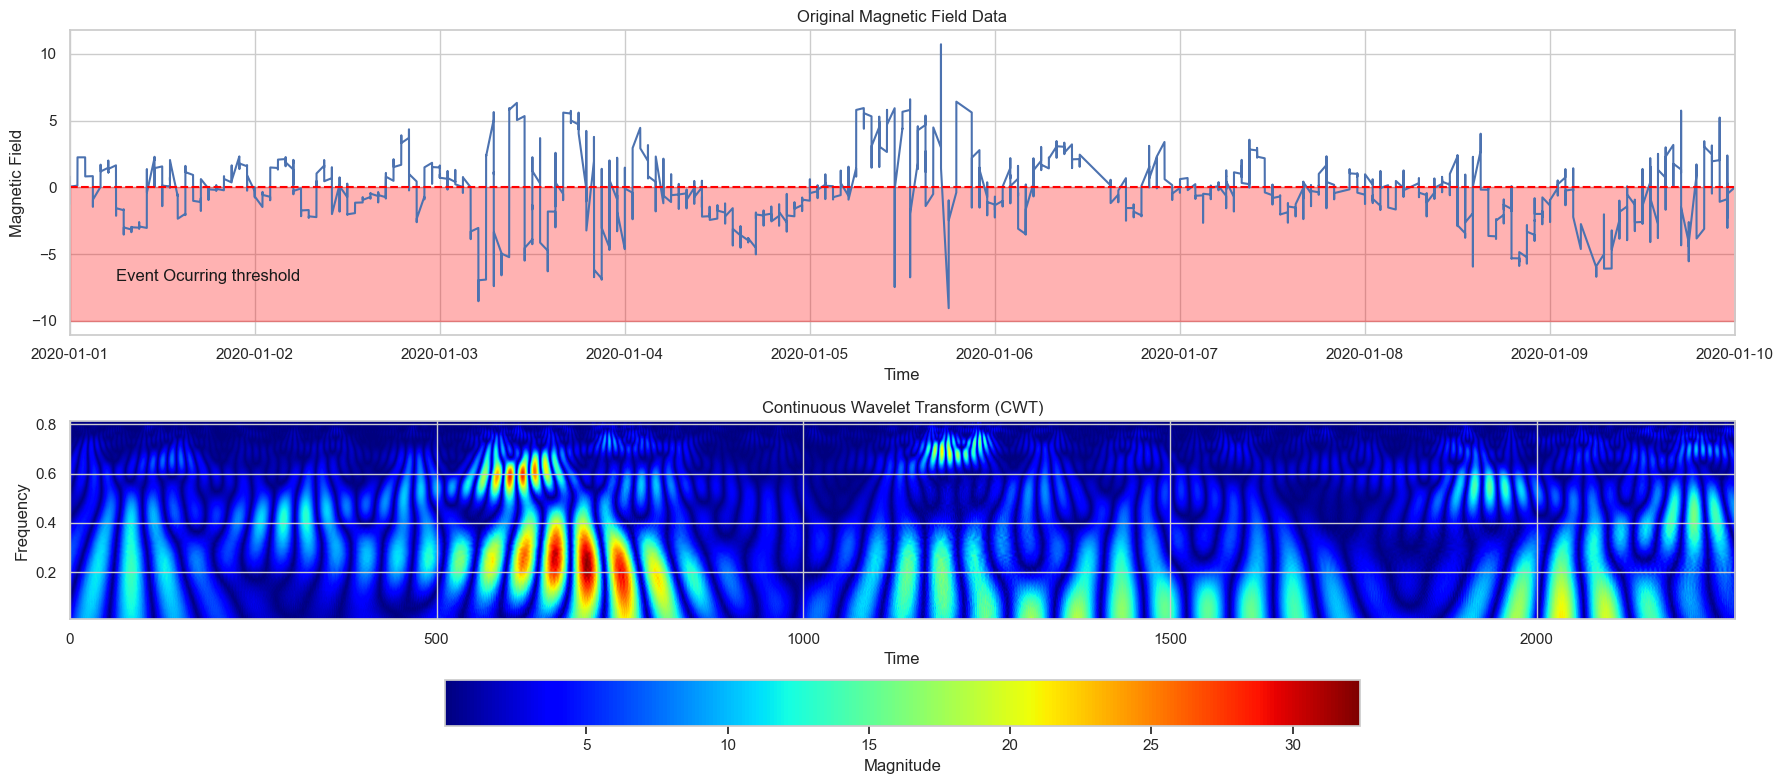

In [830]:
# Plot the original data
plt.figure(figsize=(18, 8))
plt.subplot(2, 1, 1)
plt.plot(magnetic_field)
plt.xlim(magnetic_field.index.min(),magnetic_field.index.max())
plt.title('Original Magnetic Field Data')
plt.xlabel('Time')
plt.ylabel('Magnetic Field')

plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.text(plt.xlim()[0] + 0.25, -7, 'Event Ocurring threshold', color='k', fontsize=12)

plt.fill_between([plt.xlim()[0], plt.xlim()[1]], 0, plt.ylim()[0], color='red', alpha=0.3, label='Quadrant 4')

# Agregar texto debajo de la línea


# Plot the CWT coefficients
plt.subplot(2, 1, 2)
plt.imshow(np.abs(coeffs), extent=[min(time), max(time), min(freqs), max(freqs)], aspect='auto', cmap='jet', interpolation='bilinear')

#plt.xticks(time,magnetic_field.index)
plt.title('Continuous Wavelet Transform (CWT)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(label='Magnitude',pad=0.2,location="bottom")
plt.tight_layout()
plt.show()

The plot generated with imshow in the example above shows a representation of the Continuous Wavelet Transform (CWT) of the magnetic field data in an image format. This plot can help you identify patterns and features in the data that may be related to magnetic reconnection events. Here's how to interpret the plot:

X-axis (Horizontal - Time):

The horizontal axis represents time. Each point on this axis corresponds to a moment in time in your magnetic field data.
Y-axis (Vertical - Frequency):

The vertical axis represents frequency. The different frequencies in the CWT are mapped on this axis.
Higher frequencies will be at the top and lower frequencies at the bottom.
Colors:

The colors on the graph represent the magnitude of the CWT coefficients.
Brighter or darker areas indicate higher magnitude coefficients depending on the color scale used.
Patterns and Features:

Look for patterns, lines, curves, or areas on the graph that stand out or stand out. These areas may indicate the presence of oscillations or significant changes in the magnetic field at certain frequencies and points in time.
Magnetic reconnection events may manifest themselves as distinctive features on this plot, such as peaks or wave-like structures that are not typical of regular oscillations.
Space-Frequency Interaction:

The plot provides a representation of how the magnetic field characteristics change in both time and frequency. This allows you to identify events that may be transient in nature.
Colorbar:

The colorbar to the right of the plot indicates how the colors relate to the magnitude of the coefficients. Higher magnitude values correspond to more intense colors on the color scale.
To identify magnetic reconnection events, look for unusual patterns, abrupt changes, or features that stand out on the graph. Keep in mind that accurate interpretation of the CWT may require expert knowledge in the field of space physics and magnetic reconnection. You can also experiment with different CWT parameters (such as choice of wavelet function and scales) to highlight features of interest in your data.
